# HW 2

**Author:** Gavin DeBrun

In [53]:
import numpy as np
import matplotlib.pyplot as plt


def apply_pbc(pos, lbox):
    """
    wrap positions inside simulation box

    Args:
        pos (np.array): positions, shape (natom, 3)
        lbox (float): box side length
    Returns:
        np.array: pos in box
    """

    return pos - lbox * np.round(pos / lbox)


def KE(vel, mass):
    """
    Calculate total kinetic energy.

    Args:
        vel (np.array): particle velocities, shape (nparticle, 3)
        mass (float): particle mass
    Return:
        float: total kinetic energy
    """

    return np.sum(np.linalg.norm(vel) ** 2 / 2 * mass)


def PE(distance_table):
    """
    Calculate total potential energy.

    Args:
        distance_table (np.array): distance table, shape (nparticles, nparticles)
    Return:
        float: total potential energy
    """

    n = distance_table.shape[0]
    # Create an upper triangular mask
    mask = np.triu(np.ones((n, n), dtype=bool), k=1)
    r = distance_table[mask]  # Extract the upper triangular elements of rij
    sixth = 1 / r**6
    pe = np.sum(a=4 * sixth * (sixth - 1))

    return pe


def distance(pos, lbox):
    """
    Compute distance table and rij vectors

    Args:
        pos (np.array) : particle positions, shape (nparticles, 3)
        lbox (float): side length of cubic box
    Returns:
        np.array: distance table, shape (nparticles, nparticles)
        np.array: rij vectors, shape (nparticles, nparticles, 3)
    """

    rij = pos[:, np.newaxis, :] - pos
    rij = apply_pbc(rij, lbox)
    distance_table = np.linalg.norm(rij, axis=2)

    return distance_table, rij


def F_all(rij, distance_table):
    """
    Compute force on all particles

    Args:
        rij (np.array) : distance vectors, shape (nparticles, nparticles, 3)
        distance_table (np.array): distance table, shape (nparticles, nparticles)
    Returns:
        np.array: force on all particles, shape (nparticles, 3)
    """

    n = rij.shape[0]
    mask = ~np.eye(n, dtype=bool)
    rij = rij[mask].reshape(n, -1, 3)  # Remove self-interaction
    distance_table = distance_table[mask].reshape(n, -1)  # Remove self-interaction
    sixth = (1 / distance_table) ** 6
    factor = (1 / distance_table**2) * sixth * (2 * sixth - 1)
    factor = factor[:, :, np.newaxis]
    force = np.sum(factor * rij, axis=1)

    return 24 * force

In [54]:
def InitPositionCubic(Ncube, L):
    """
    Places Ncube^3 atoms in a cubic box

    Args:
        Ncube (int): cube root number of atoms
        L (float): box side length
    Returns:
        np.array: positions, shape (Ncube**3, 3)
    """

    rs = L / Ncube
    roffset = L / 2 - rs / 2
    x = np.linspace(-roffset, roffset, Ncube)
    # Create a grid of positions using numpy broadcasting
    x, y, z = np.meshgrid(x, x, x, indexing="ij")
    # Stack the positions into a single array
    position = np.column_stack((x.ravel(), y.ravel(), z.ravel()))

    return position


def InitVelocity(N, T0, mass=1.0, seed=1):
    """
    Initialize velocities from a Maxwell-Boltzmann distribution

    Args:
        N (int): number of particles
        T0 (float): temperature
        mass (float): particle mass
        seed (int): random seed
    Returns:
        np.array: velocities, shape (N, 3)
    """

    dim = 3
    np.random.seed(seed)
    # generate N x dim array of random numbers, and shift to be [-0.5, 0.5)
    velocity = np.random.random((N, dim)) - 0.5
    # get the average along the first axis
    meanV = np.sum(velocity, axis=0) / N
    # subtract off meanV, so there is no net momentum
    velocity -= meanV
    # calculate the total of V^2
    ke = np.sum(velocity * velocity)
    # calculate a scaling factor
    vscale = np.sqrt(dim * N * T0 / (mass * ke))
    # rescale
    velocity *= vscale

    return velocity


def VerletNextR(r_t, v_t, a_t, h):
    """
    Return new positions after one Verlet step

    Args:
        r_t (np.array): positions at time t, shape (nparticles, ndim)
        v_t (np.array): velocities at time t, shape (nparticles, ndim)
        a_t (np.array): accelerations at time t, shape (nparticles, ndim)
        h (float): timestep
    Returns:
        np.array: positions at time t+h, shape (nparticles, ndim)
    """

    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    r_t_plus_h = r_t + v_t * h + 0.5 * a_t * h * h

    return r_t_plus_h


def VerletNextV(v_t, a_t, a_t_plus_h, h):
    """
    Return new velocities after one Verlet step

    Args:
        v_t (np.array): velocities at time t, shape (nparticles, ndim)
        a_t (np.array): accelerations at time t, shape (nparticles, ndim)
        a_t_plus_h (np.array): accelerations at time t+h, shape (nparticles, ndim)
        h (float): timestep

    Returns:
        np.array: velocities at time t+h, shape (nparticles, ndim)
    """

    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    v_t_plus_h = v_t + 0.5 * (a_t + a_t_plus_h) * h

    return v_t_plus_h

In [295]:
def simulate(Ncube, T0, L, M, steps, h):
    """
    Initialize and run a simulation in a Ncube**3 box, for steps

    Args:
        Ncube (int): cube root number of atoms
        T0 (float): temperature
        L (float): box side length
        M (float): particle mass
        steps (int): number of steps to run
        h (float): timestep
    Returns:
        np.array: total energy, shape (steps,)
    """
    N = Ncube**3
    R = InitPositionCubic(Ncube, L)
    V = InitVelocity(N, T0, M)

    A = np.zeros((N, 3))
    E = np.zeros(steps)

    distance_table, rij = distance(R, L)

    # Calculate initial Forces and accelerations (N x 3 array)
    F = F_all(rij, distance_table)
    A = F / M

    for t in range(0, steps):
        # Calculate energy
        E[t] = KE(V, M)
        E[t] += PE(distance_table)

        # Calculate next positions and apply PBC
        nR = VerletNextR(R, V, A, h)
        nR = apply_pbc(nR, L)
        distance_table, rij = distance(nR, L)

        # Calculate next forces, accelerations, and velocities
        nF = F_all(rij, distance_table)
        nA = nF / M
        nV = VerletNextV(V, A, nA, h)

        # update positions, velocities, accelerations and forces
        R, V, A, F = nR, nV, nA, nF

    return E

### 1)

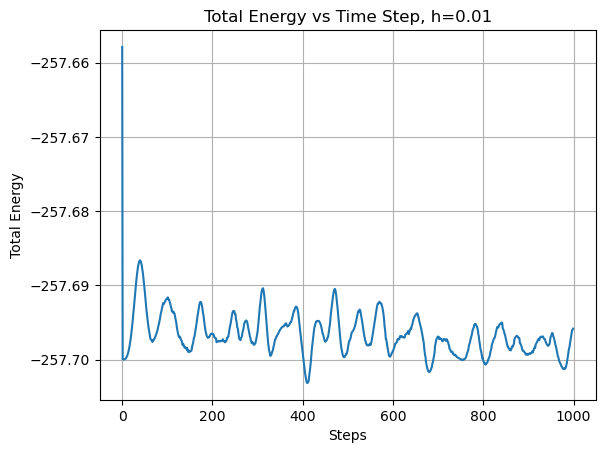

In [296]:
# mass
M = 48.0
# number of Particles
Ncube = 4
N = Ncube**3
# box side length
L = 4.2323167
# temperature
T0 = 0.728
# number of steps
steps = 1000
# timestep
h = 0.01

E = simulate(Ncube, T0, L, M, steps, h)

plt.plot(E)
plt.xlabel("Steps")
plt.ylabel("Total Energy")
plt.title("Total Energy vs Time Step, h=0.01")
plt.grid()
plt.show()

After the brief transient period, the system settles to a steady state with small fluctuations around the mean energy.

### 2)

In [297]:
import warnings

# Ignore divide by zero warning due to instability at high h
warnings.filterwarnings("ignore")

hs = np.array(
    [
        1,
        0.5,
        0.25,
        0.2,
        0.175,
        0.15,
        0.125,
        0.1,
        0.05,
        0.025,
        0.01,
        0.005,
        0.0025,
        0.001,
        0.0005,
        0.00025,
        0.0001,
    ]
)
Es = np.zeros((hs.shape[0], steps))

for i, h in enumerate(hs):
    Es[i] = simulate(Ncube, T0, L, M, steps, h)
    Es[i][np.isnan(Es[i])] = np.inf

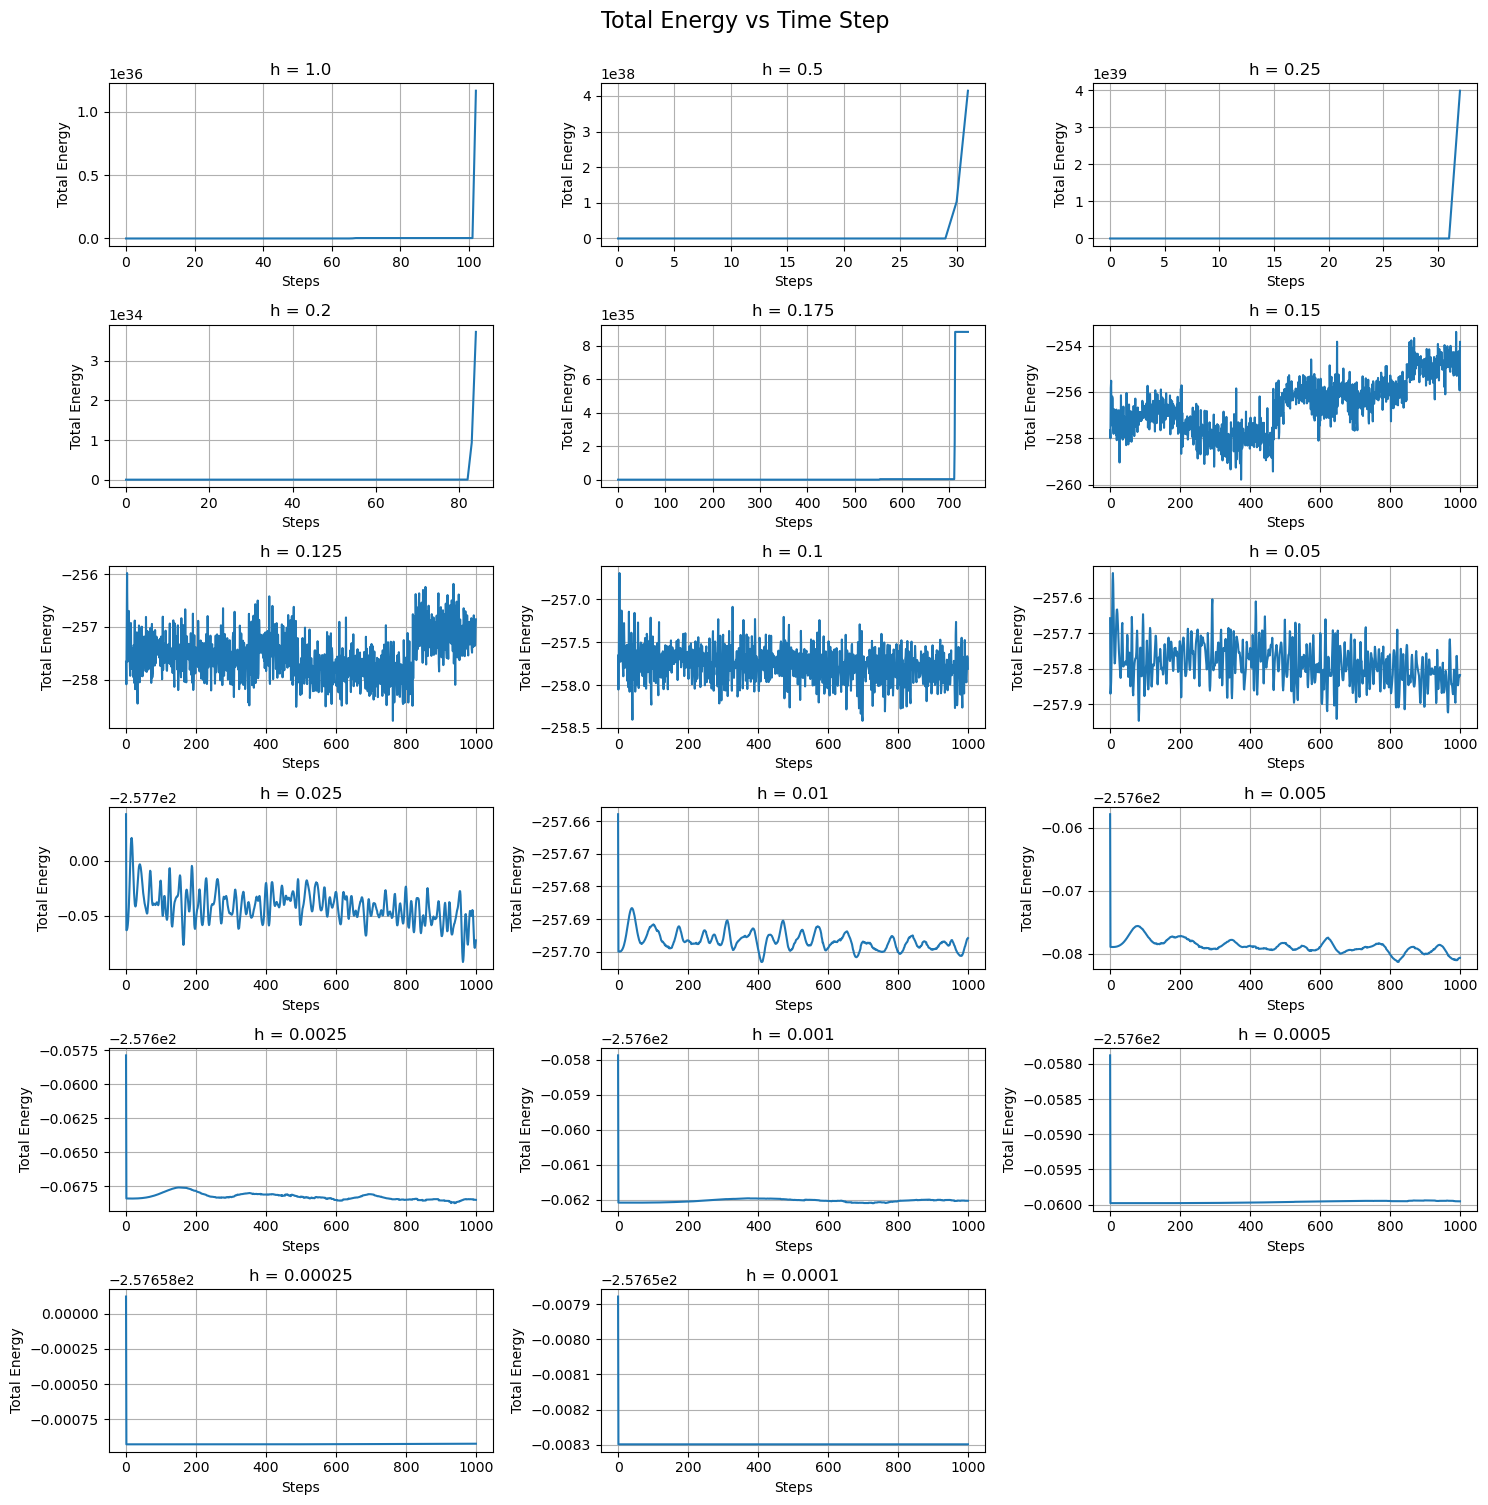

In [298]:
nsims = hs.shape[0]
ncols = 3
nrows = nsims // ncols

if nsims % ncols != 0:
    nrows += 1

fig = plt.figure(figsize=(15, 15))
spec = fig.add_gridspec(nrows, ncols)

for i in range(nsims):
    ax = fig.add_subplot(spec[i // ncols, i % ncols])
    ax.plot(Es[i])
    ax.set_title(f"h = {hs[i]}")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Total Energy")
    ax.grid()

fig.suptitle("Total Energy vs Time Step", fontsize=16, y=1)
plt.tight_layout()
plt.show()

In [299]:
def actime(a):
    mu = np.mean(a)
    std = np.std(a, ddof=1)
    N = a.shape[0]
    ts = np.arange(0, N, 1)

    a_diffs = np.zeros((N, N))

    for t in ts:
        a_diffs[t][: N - t] = (a[: N - t] - mu) * (a[t:] - mu)

    autocorrelation = np.sum(a_diffs, axis=1) / std**2 / (N - ts)
    tcutoff = (
        np.where(autocorrelation <= 0)[0][0] if (autocorrelation <= 0).any() else 0
    )
    kappa = 1 + 2 * np.sum(autocorrelation[1:tcutoff])

    return kappa, tcutoff


def stderr(a):
    kappa, tcutoff = actime(a)
    N = a.shape[0]
    std = np.std(a, ddof=1)

    return std / np.sqrt(N / kappa)

Step Size = 1.0, t-cutoff = 0, mean(E) = inf std(E) = inf
Step Size = 0.5, t-cutoff = 0, mean(E) = inf std(E) = inf
Step Size = 0.25, t-cutoff = 0, mean(E) = inf std(E) = inf
Step Size = 0.2, t-cutoff = 0, mean(E) = inf std(E) = inf
Step Size = 0.175, t-cutoff = 0, mean(E) = inf std(E) = inf
Step Size = 0.15, t-cutoff = 371, mean(E) = -256.1596 std(E) = 1.125514
Step Size = 0.125, t-cutoff = 118, mean(E) = -257.5705 std(E) = 0.433136
Step Size = 0.1, t-cutoff = 2, mean(E) = -257.7725 std(E) = 0.201961
Step Size = 0.05, t-cutoff = 4, mean(E) = -257.7854 std(E) = 0.055961
Step Size = 0.025, t-cutoff = 8, mean(E) = -257.7413 std(E) = 0.014304
Step Size = 0.01, t-cutoff = 19, mean(E) = -257.6966 std(E) = 0.002666
Step Size = 0.005, t-cutoff = 195, mean(E) = -257.6791 std(E) = 0.000801
Step Size = 0.0025, t-cutoff = 370, mean(E) = -257.6683 std(E) = 0.000166
Step Size = 0.001, t-cutoff = 135, mean(E) = -257.662 std(E) = 3.7e-05
Step Size = 0.0005, t-cutoff = 296, mean(E) = -257.66 std(E) = 

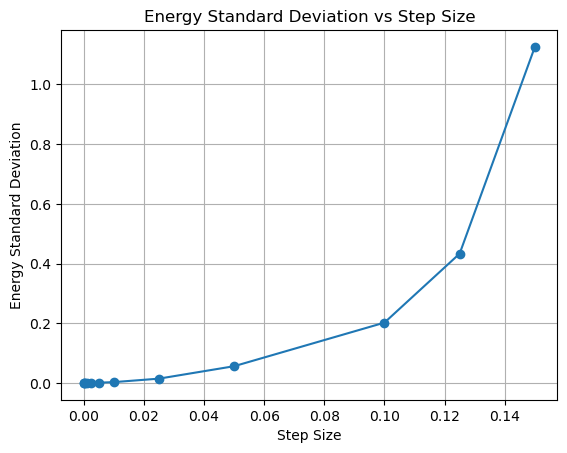

In [308]:
std_Es = np.zeros(hs.shape[0])
mu_Es = np.zeros(hs.shape[0])
for i, E in enumerate(Es):
    kappa, tcutoff = actime(E)
    stderr_mu = stderr(E)
    std_E = np.std(E[tcutoff:], ddof=1)
    mu_E = np.mean(E[tcutoff:])
    if np.isnan(std_E):
        std_E = np.inf
    if np.isnan(mu_E):
        mu_E = np.inf

    print(
        f"Step Size = {hs[i]}, t-cutoff = {tcutoff}, mean(E) = {np.round(mu_E,4)}",
        f"std(E) = {np.round(std_E,6)}",
    )

    std_Es[i] = std_E
    mu_Es[i] = mu_E

plt.plot(hs, std_Es, marker="o")
plt.xlabel("Step Size")
plt.ylabel("Energy Standard Deviation")
plt.title("Energy Standard Deviation vs Step Size")
plt.grid()
plt.show()

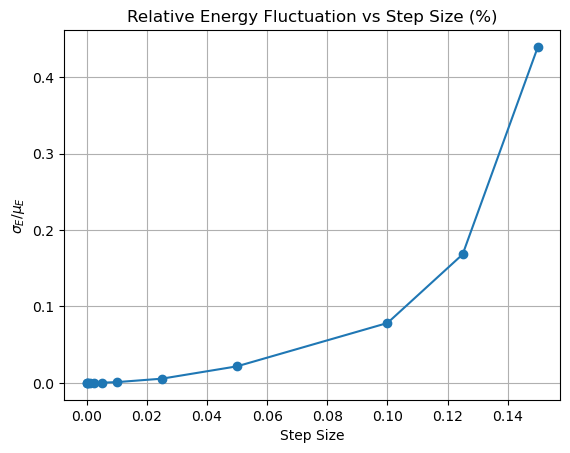

In [301]:
relative_std = 100 * np.abs(std_Es / mu_Es)
plt.plot(hs, relative_std, marker="o")
plt.xlabel("Step Size")
plt.ylabel(r"$\sigma_{E} / \mu_{E}$")
plt.title("Relative Energy Fluctuation vs Step Size (%)")
plt.grid()

### 3)

If we pick a large time step, the system will not be able to settle to a steady state. Instead, the energy will increase without bound. This is because the positions change too rapidly, resulting in large repulsive forces.

### 4)

The highest step size we can choose to maintain a stable mean and small fluctuations is about 0.1. Any higher than this, and the mean energy appears to be unstable.

### 5)

In [272]:
def TaylorNextR(r_t, v_t, a_t, h):
    """
    Return new positions after one Taylor step

    Args:
        r_t (np.array): positions at time t, shape (nparticles, ndim)
        v_t (np.array): velocities at time t, shape (nparticles, ndim)
        a_t (np.array): accelerations at time t, shape (nparticles, ndim)
        h (float): timestep
    Returns:
        np.array: positions at time t+h, shape (nparticles, ndim)
    """

    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    r_t_plus_h = r_t + v_t * h + 0.5 * a_t * h * h

    return r_t_plus_h


def TaylorNextV(v_t, a_t, h):
    """
    Return new velocities after one Taylor step

    Args:
        v_t (np.array): velocities at time t, shape (nparticles, ndim)
        a_t (np.array): accelerations at time t, shape (nparticles, ndim)
        h (float): timestep
    Returns:
        np.array: velocities at time t+h, shape (nparticles, ndim)
    """

    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    v_t_plus_h = v_t + a_t * h

    return v_t_plus_h

In [278]:
def simulateTaylor(Ncube, T0, L, M, steps, h):
    """
    Initialize and run a simulation in a Ncube**3 box, for steps

    Args:
        Ncube (int): cube root number of atoms
        T0 (float): temperature
        L (float): box side length
        M (float): particle mass
        steps (int): number of steps to run
        h (float): timestep
    Returns:
        np.array: total energy, shape (steps,)
    """
    N = Ncube**3
    R = InitPositionCubic(Ncube, L)
    V = InitVelocity(N, T0, M)

    A = np.zeros((N, 3))
    E = np.zeros(steps)

    distance_table, rij = distance(R, L)
    # Calculate initial Forces and accelerations (N x 3 array)
    F = F_all(rij, distance_table)
    A = F / M

    for t in range(0, steps):
        # Calculate energy
        E[t] = KE(V, M)
        E[t] += PE(distance_table)

        # Calculate next positions and apply PBC
        nR = TaylorNextR(R, V, A, h)
        nR = apply_pbc(nR, L)
        distance_table, rij = distance(nR, L)

        # Calculate next forces, accelerations, and velocities
        nF = F_all(rij, distance_table)
        nA = nF / M
        nV = TaylorNextV(V, A, h)

        # update positions, velocities, accelerations and forces
        R, V, A, F = nR, nV, nA, nF

    return E

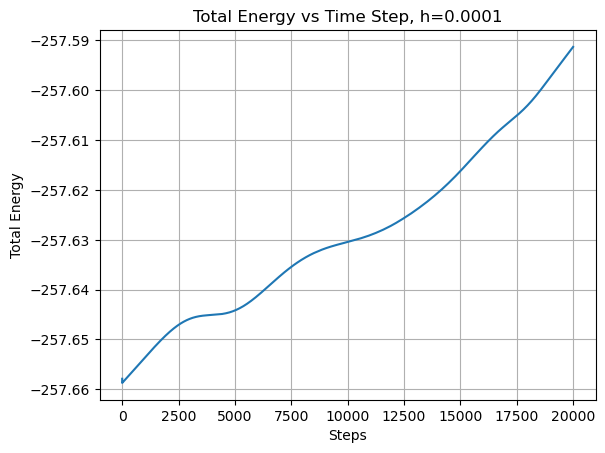

In [307]:
# mass
M = 48.0
# number of Particles
Ncube = 4
N = Ncube**3
# box side length
L = 4.2323167
# temperature
T0 = 0.728
# number of steps
steps = 20000
# timestep
h = 0.0001

E = simulateTaylor(Ncube, T0, L, M, steps, h)

plt.plot(E)
plt.xlabel("Steps")
plt.ylabel("Total Energy")
plt.title("Total Energy vs Time Step, h=0.0001")
plt.grid()
plt.show()

The energy grows unbounded because the explicit Euler integrator is not simpletic.

### 6)

Velocity-Verlet gives: 

$r(t + \Delta t) = r(t) + \Delta t \cdot v(t) + \frac{\Delta t^{2}}{2}\cdot a(t)$

$v(t + \Delta t) = v(t) + \frac{\Delta t}{2} \cdot (a(t) + a(t + \Delta t))$

Then,

$r(t + \Delta t - \Delta t) = r(t + \Delta t) - \Delta t \cdot v(t + \Delta t) + \frac{\Delta t^{2}}{2}\cdot a(t + \Delta t)$

$r(t) = r(t) - \Delta t \cdot v(t + \Delta t) + \frac{\Delta t^{2}}{2}\cdot a(t)$

$r(t) = -\Delta t \cdot(v(t) + \frac{\Delta t}{2} \cdot (a(t) + a(t+\Delta t))) + \frac{\Delta t^{2}}{2}\cdot a(t + \Delta t)$

$r(t) = r(t)$. QED.

Similarly, 

$v(t + \Delta t - \Delta t) = v(t + \Delta t) - \frac{\Delta t}{2} \cdot (a(t + \Delta t) + a(t + \Delta t - \Delta t))$

$v(t) = v(t) + \frac{\Delta t}{2} \cdot (a(t + \Delta t) + a(t)) - \frac{\Delta t}{2}\cdot (a(t+ \Delta t) + a(t))$

$v(t) = v(t)$. QED.

Thus, if we have $r(t)$ and $r(t + \Delta t)$, we can find $r(t - \Delta t)$ following from:

$r(t + \Delta t) = r(t) + v(t)\Delta t +\frac{\Delta t^{2}}{2}a(t)$ and

$r(t - \Delta t) = r(t) - v(t)\Delta t + \frac{\Delta t^{2}}{2}a(t)$

then $r(t -\Delta t) = 2r(t) - r(t+\Delta t) + \Delta t^{2}a(t)$

### 7)

The accuracy of both position and velocity are $O(\Delta t ^{2})$. However, due to the $\frac{1}{r^{14}}$ term in the force, machine precision will limit the accuracy of our force calculations and susequent position and velocity updates for small $r$. Further, the round off errors induced throughout the simulation will accumulate. 